# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [3]:
# Enable autoreload
%load_ext autoreload
%autoreload 2


# Regular imports
import  numpy as np
import  pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import  matplotlib.pyplot as plt
import os

from supp_material.utils import save_results_to_csv
from supp_material.preprocessing import data_preprocessing
from supp_material.xgboost_model import launch_xgb
from supp_material.double_model import launch_double_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [13]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [5]:
X_train.head()


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [6]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [7]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [8]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_c2lean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

Spearman correlation for the train set: 27.9%


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [9]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [10]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)


Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 


Run an XGBoost model as an alternative benchmark

In [62]:

nan_report = X_test.isna().sum().to_frame('NaN_Count')
nan_report['NaN_Percent'] = (nan_report['NaN_Count'] / len(X_test)) * 100
print(nan_report)


                  NaN_Count  NaN_Percent
ID                        0     0.000000
DAY_ID                    0     0.000000
COUNTRY                   0     0.000000
DE_CONSUMPTION            0     0.000000
FR_CONSUMPTION            0     0.000000
DE_FR_EXCHANGE            9     1.376147
FR_DE_EXCHANGE            9     1.376147
DE_NET_EXPORT            47     7.186544
FR_NET_EXPORT            24     3.669725
DE_NET_IMPORT            47     7.186544
FR_NET_IMPORT            24     3.669725
DE_GAS                    0     0.000000
FR_GAS                    0     0.000000
DE_COAL                   0     0.000000
FR_COAL                   0     0.000000
DE_HYDRO                  0     0.000000
FR_HYDRO                  0     0.000000
DE_NUCLEAR                0     0.000000
FR_NUCLEAR                0     0.000000
DE_SOLAR                  0     0.000000
FR_SOLAR                  0     0.000000
DE_WINDPOW                0     0.000000
FR_WINDPOW                0     0.000000
DE_LIGNITE      

#Preprocess the dataset

In [49]:
# Preprocess datasets


print("Preprocessing training data...")
X_train_processed, X_test_processed = data_preprocessing(X_train = X_train,Y_train=Y_train, X_test = X_test)
print(len(X_train_processed))
#X_train_processed.head()


Preprocessing training data...
95th percentile DE_FR_EXCHANGE: 1.3872058761434596, count >= quantile: 74
95th percentile FR_DE_EXCHANGE: 1.7027255556733814, count >= quantile: 74
95th percentile DE_FR_EXCHANGE: 1.4058082668226408, count >= quantile: 34
95th percentile FR_DE_EXCHANGE: 1.4898001313487856, count >= quantile: 33
1494


Create interaction constraints between countries

In [27]:
from supp_material.xgboost_model import create_country_interaction_constraints

interaction_constraints=create_country_interaction_constraints(X_train_processed.columns)
interaction_constraints


[Index(['DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL',
        'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE',
        'DE_RESIDUAL_LOAD', 'DE_RAIN', 'DE_WIND', 'DE_TEMP',
        'is_market_decupled'],
       dtype='object'),
 Index(['FR_CONSUMPTION', 'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'FR_COAL',
        'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD',
        'FR_RAIN', 'FR_WIND', 'FR_TEMP'],
       dtype='object')]

In [59]:

param_grid = {
        'n_estimators': [   500, 600,800 ],
        'max_depth': [ 3, 4, 7 ],
        'learning_rate': [  0.05, 0.001,],
        #'subsample': [0.8, 1.0],
        #'colsample_bytree': [0.8, 1.0],
        #'min_child_weight': [1, 3, 5]
    }



X_train_processed, X_test_processed = data_preprocessing(X_train = X_train,Y_train=Y_train, X_test = X_test, convert_categorical=True)



predictions = launch_xgb(
    X_train=X_train_processed,
    y_train=Y_train['TARGET'],
    X_test=X_test_processed,
    run_test=True,
    task_type='regression',  # or 'classification'
    cv_folds=10,
    #params_constrained=interaction_constraints,
    param_grid=param_grid
)



Starting XGBoost Model Training Pipeline...
------------------------------------------------------------
Starting 10-fold cross-validation...
Fitting 10 folds for each of 18 candidates, totalling 180 fits

CROSS-VALIDATION RESULTS

Best Parameters Found:
  learning_rate: 0.001
  max_depth: 7
  n_estimators: 800

Best CV Score (Spearman Correlation): 0.2323

Training Set Performance:
  Spearman Correlation: 0.5445 (p-value: 4.6272e-116)
  MSE: 0.7423
  RMSE: 0.8616
  R²: 0.3060

Holdout (80/20) evaluation with fresh training using best parameters...
Spearman correlation on the holdout set: 0.1350

Generating predictions for test set...
Test predictions generated: 654 samples


Save the results in a csv file

In [39]:
save_results_to_csv(dataset_wit_IDs = X_test, predictions= predictions, file_name='xgb_test_performances')

IDs length: 654, Predictions length: 654
True
Saved predictions to `./xgb_test_performances_20251117_130534.csv`


Run TabPFN


In [ ]:

from tabpfn import TabPFNRegressor

from sklearn.model_selection import train_test_split
from tabpfn.constants import ModelVersion
# Split indices to keep alignment
X_80_train, X_20_test, y_80_train, y_20_test = train_test_split(
    X_train_processed, Y_train, test_size=0.2, random_state=41, shuffle=True
)

#test performances
regressor_train = TabPFNRegressor()  # Uses TabPFN-2.5 weights, trained on synthetic data only.

regressor_train = TabPFNRegressor.create_default_for_version(ModelVersion.V2)


# To use TabPFN v2:
# regressor = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
regressor_train.fit(X_80_train, y_80_train['TARGET'])

# Predict on the test set
predictions_train = regressor_train.predict(X_20_test)

holdout_spear = spearmanr( predictions_train,y_20_test['TARGET']).correlation
print(f"Spearman correlation on the holdout set: { holdout_spear:.4f}")



regressor = TabPFNRegressor()  # Uses TabPFN-2.5 weights, trained on synthetic data only.
# To use TabPFN v2:
# regressor = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
regressor.fit(X_train_processed, Y_train['TARGET'])

# Predict on the test set
predictions = regressor.predict(X_test_processed)

# Save the results in a csv file
save_results_to_csv(dataset_wit_IDs = X_test, predictions= predictions, file_name='tabpfn_test_performances')

Spearman correlation on the holdout set: 0.2667


In [12]:


param_grid = {
        'n_estimators': [   5000, ],
        'max_depth': [ 5, 7 ,8],
        'learning_rate': [0.01, 0.001, 0.0005],
        #'subsample': [0.8, 1.0],
        #'colsample_bytree': [0.8, 1.0],
        #'min_child_weight': [1, 3, 5]
    }

predictions = launch_double_model(X_train=X_train, Y_train=Y_train,X_test=X_test, param_grid=param_grid)

Filled 0 rows. Remaining missing COUNTRY: 0
Filled 0 rows. Remaining missing COUNTRY: 0
Unique DAY_ID count: 289
0.33-quantile threshold: 0.14279523115371576
Number of HOLIDAY days: 96
Unique DAY_ID count: 643
0.33-quantile threshold: 0.04879532822672666
Number of HOLIDAY days: 212

=== Cross-validation for COUNTRY == DE ===
Starting 5-fold cross-validation...


ValueError: Found input variables with inconsistent numbers of samples: [643, 1286]

Filled 0 rows. Remaining missing COUNTRY: 0


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


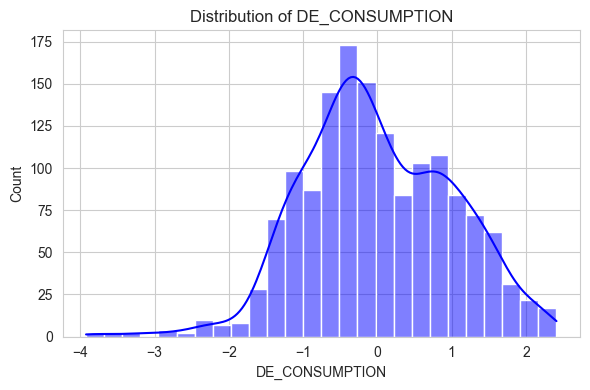

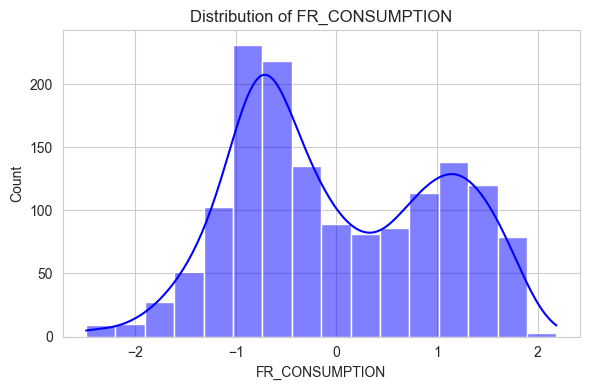

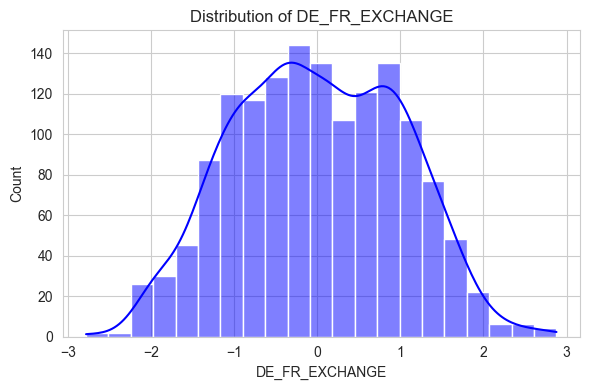

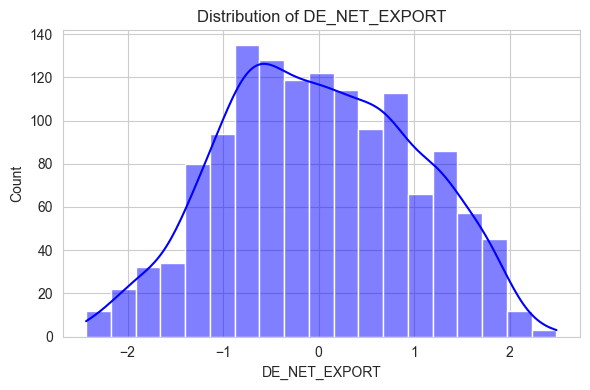

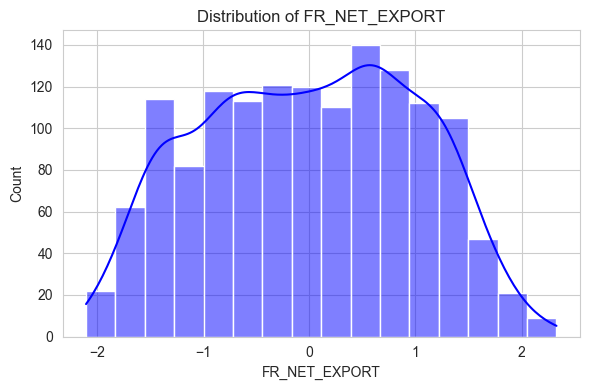

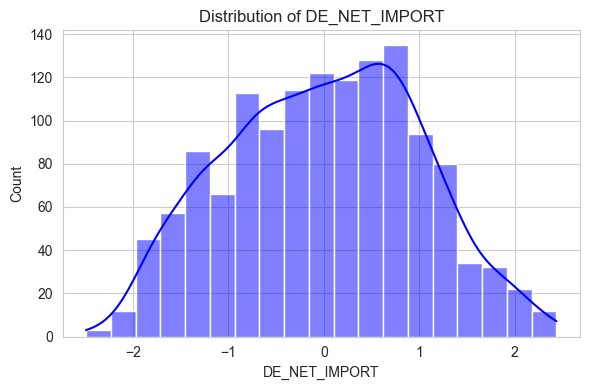

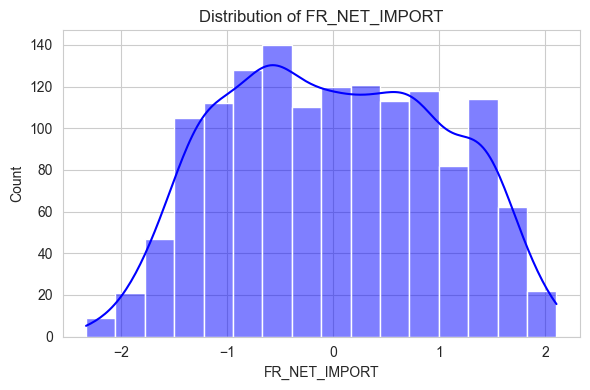

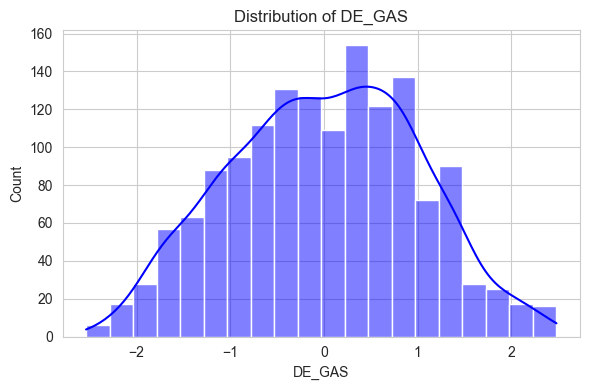

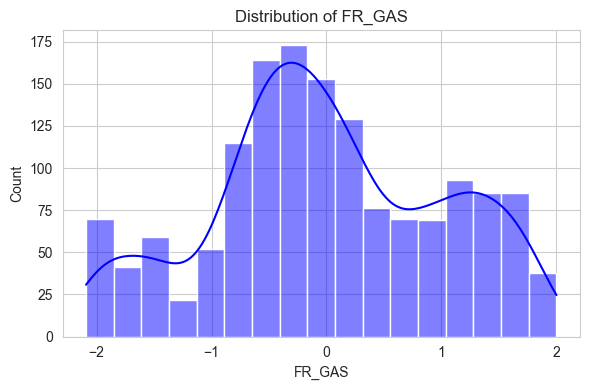

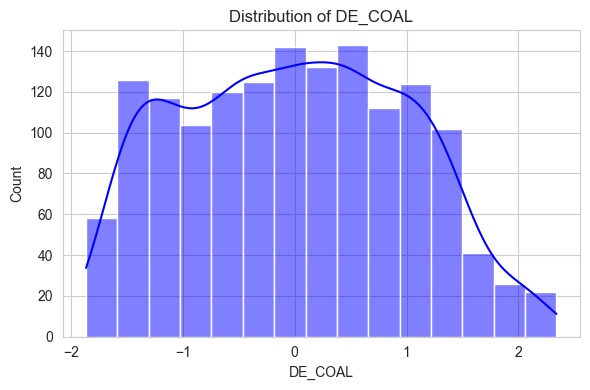

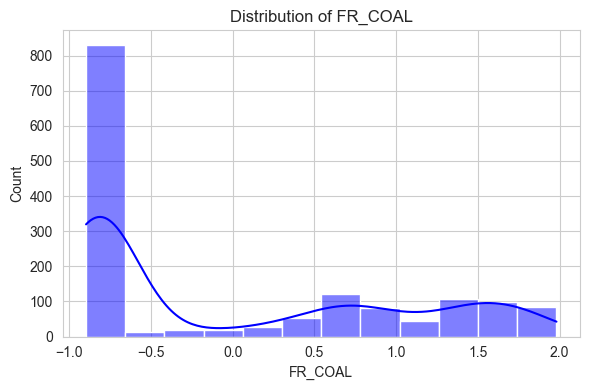

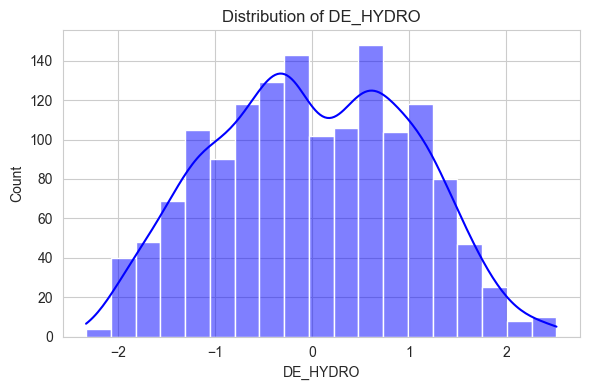

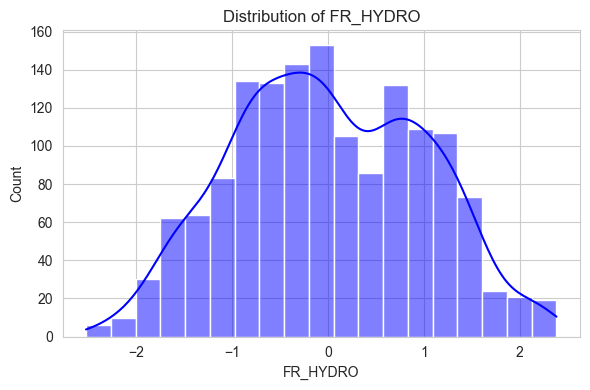

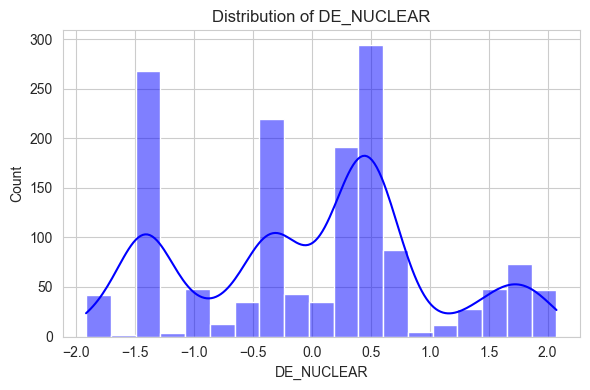

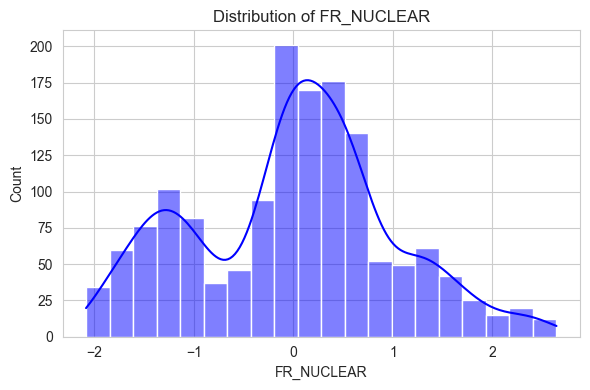

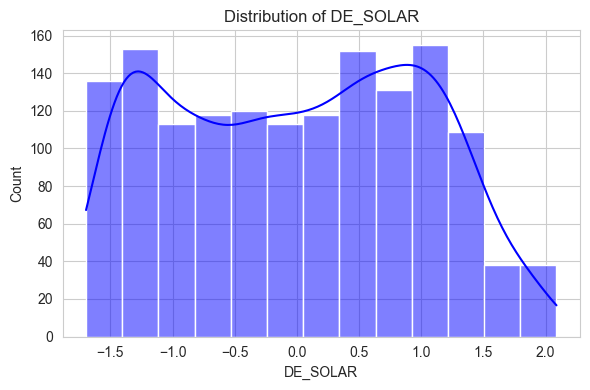

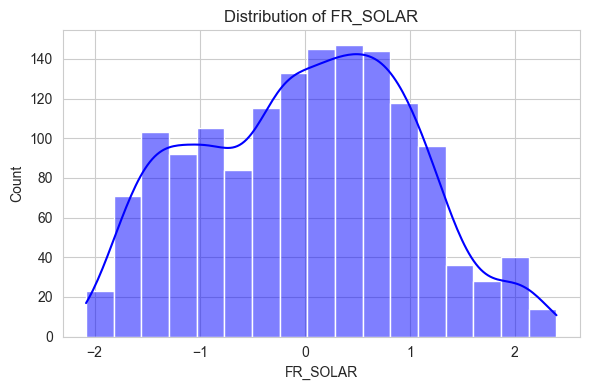

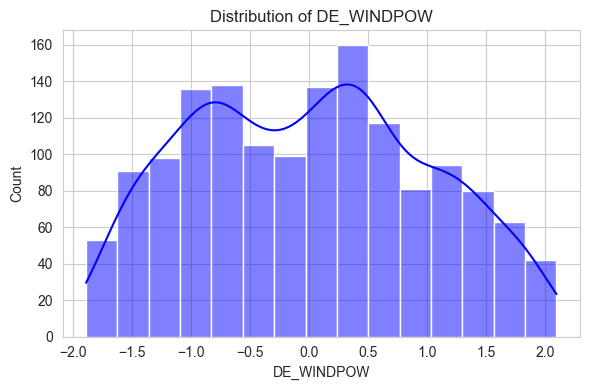

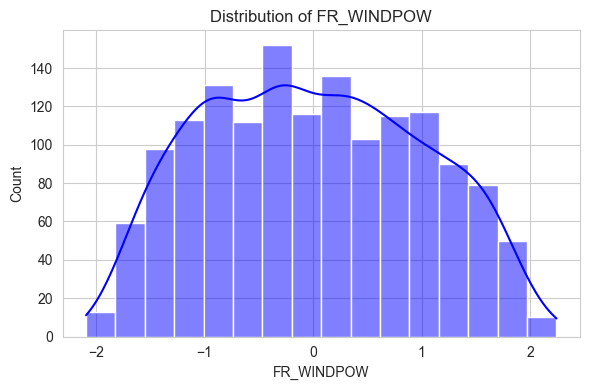

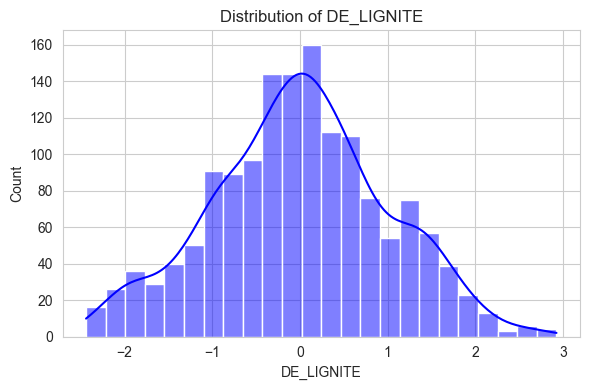

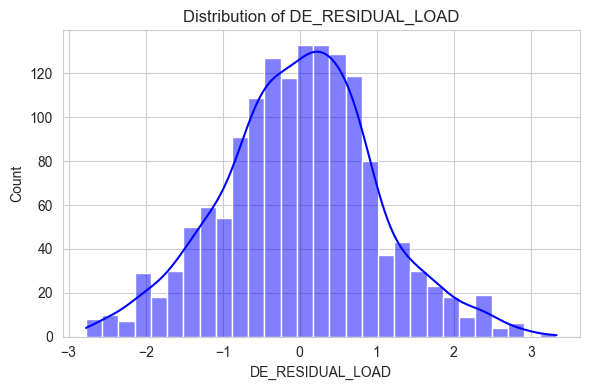

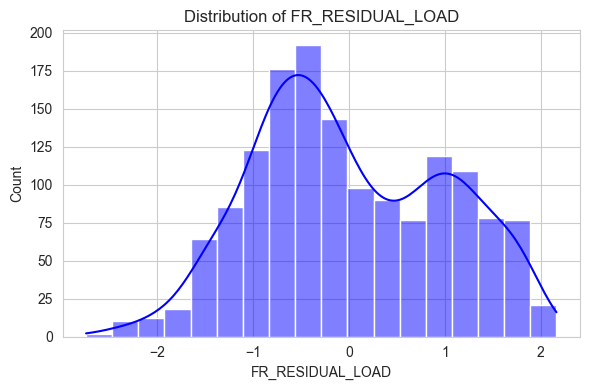

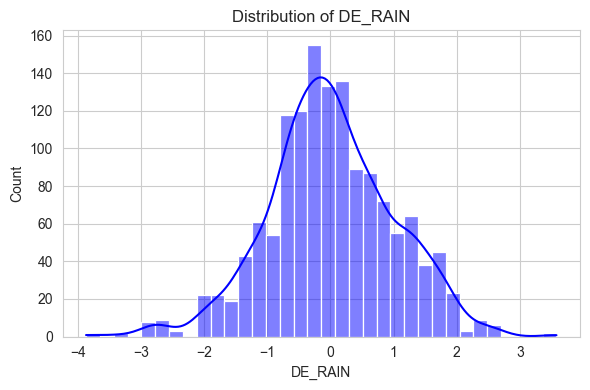

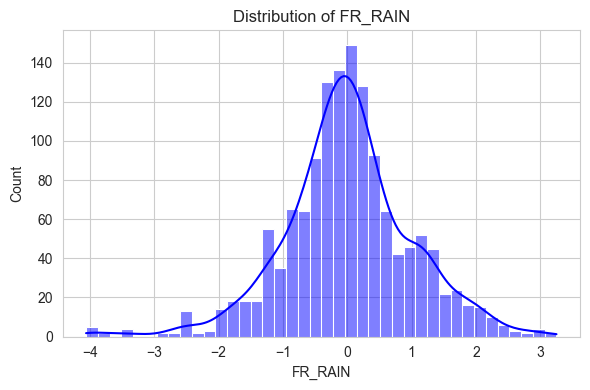

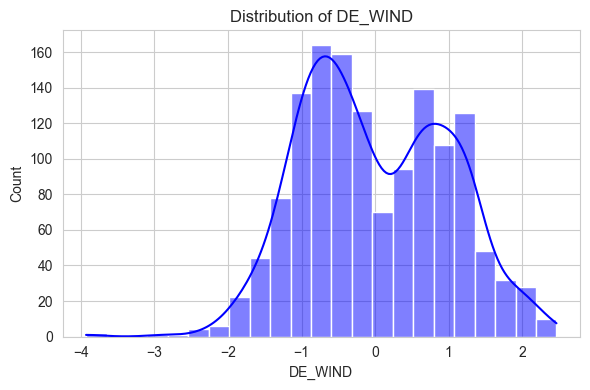

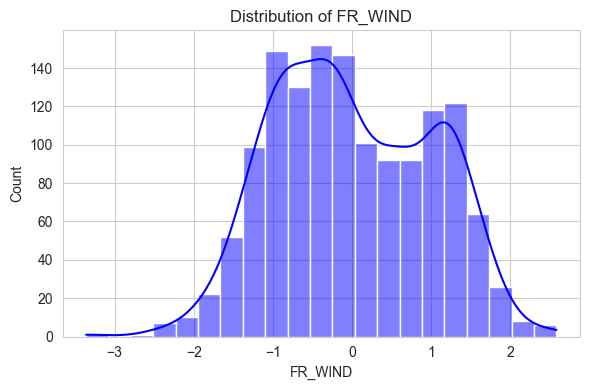

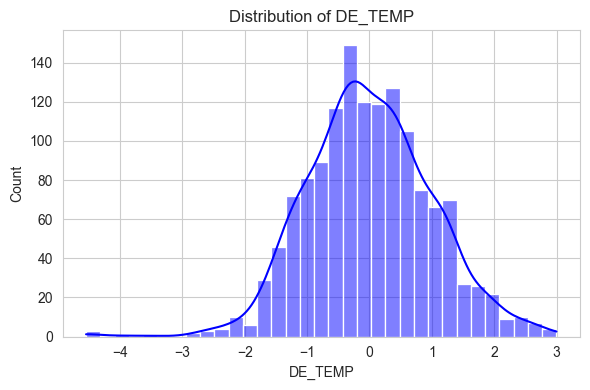

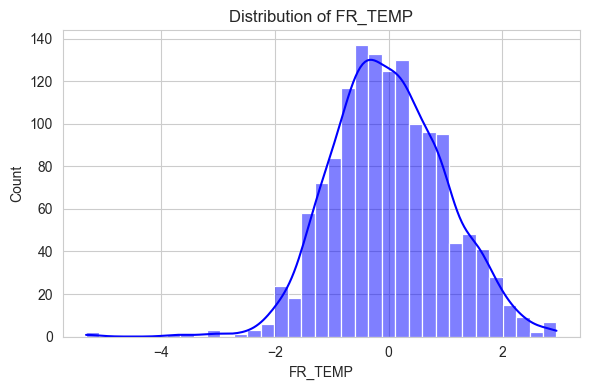

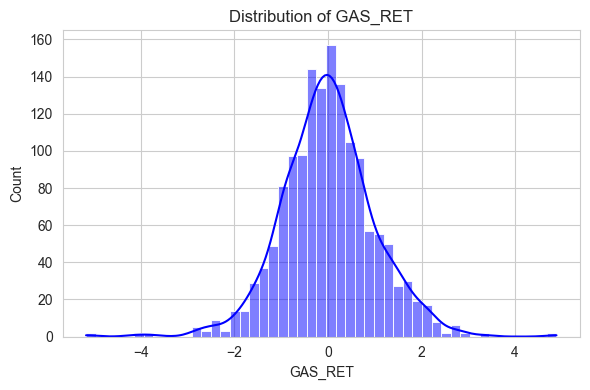

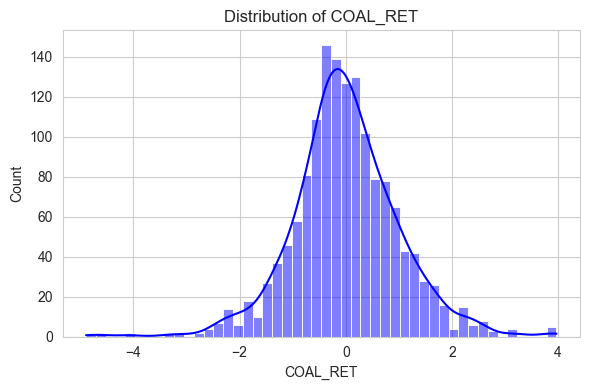

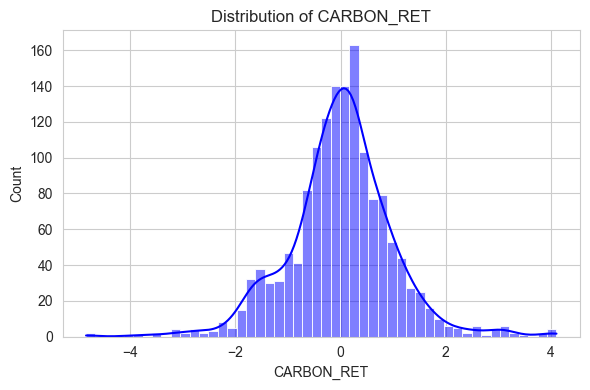

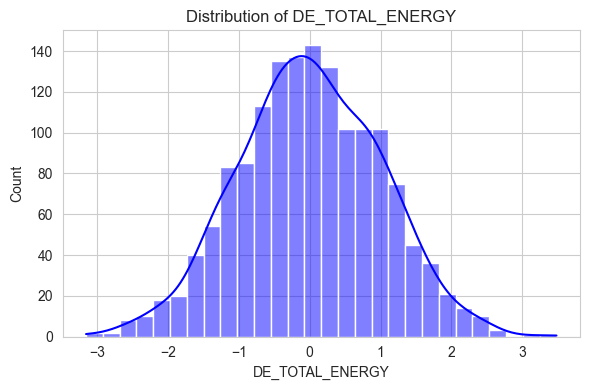

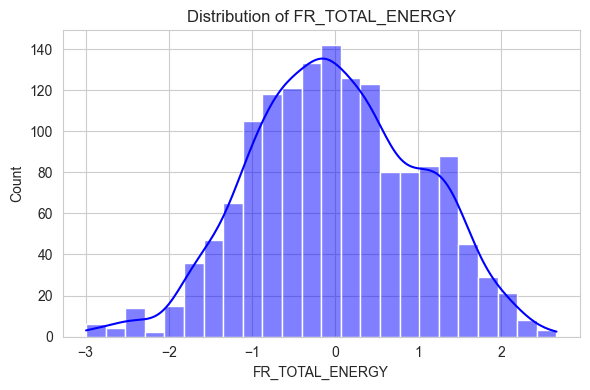

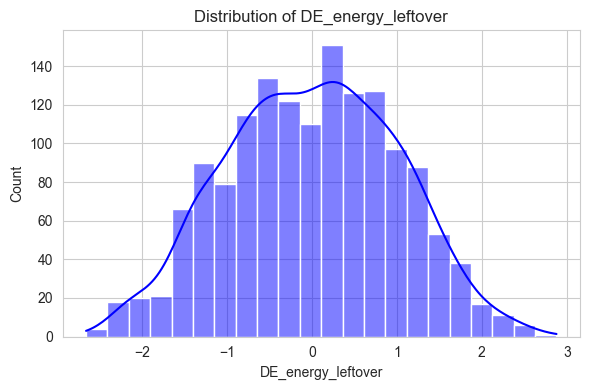

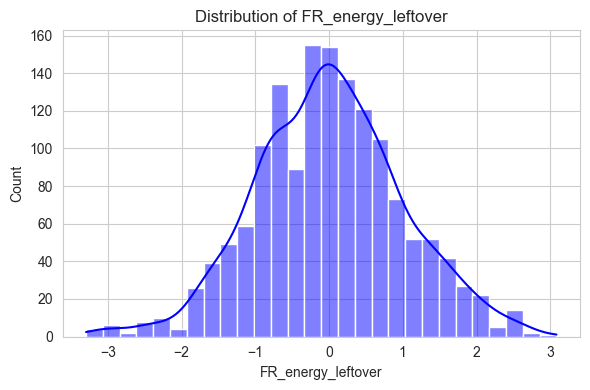

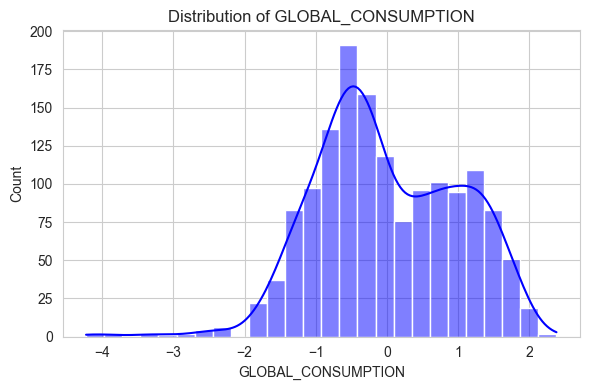

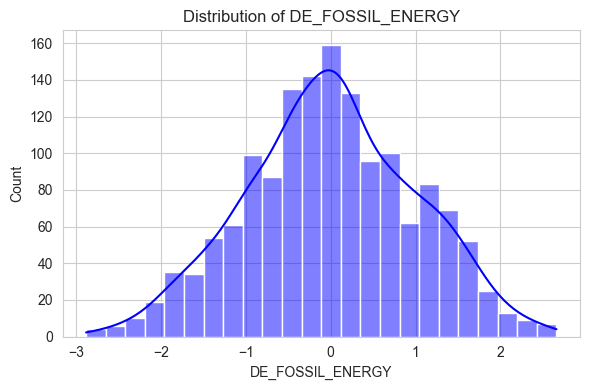

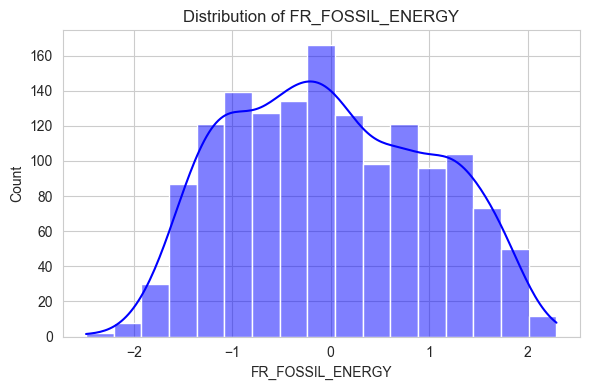

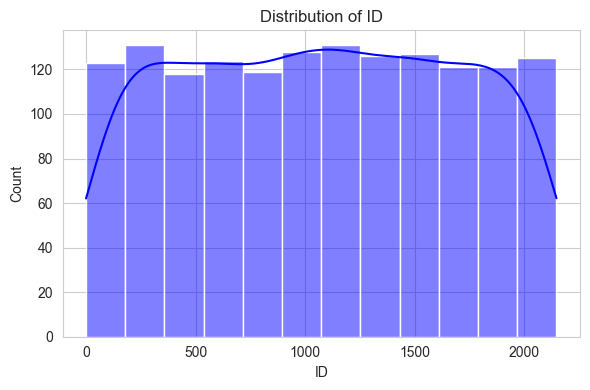

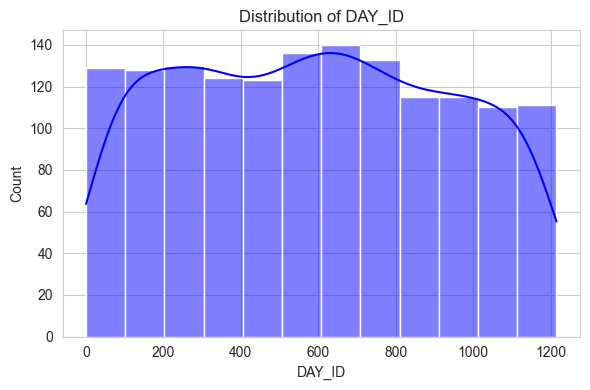

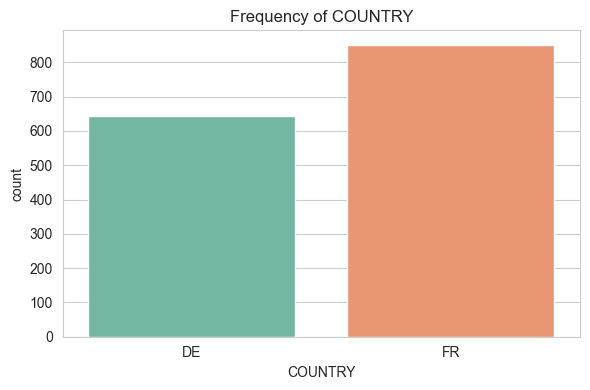

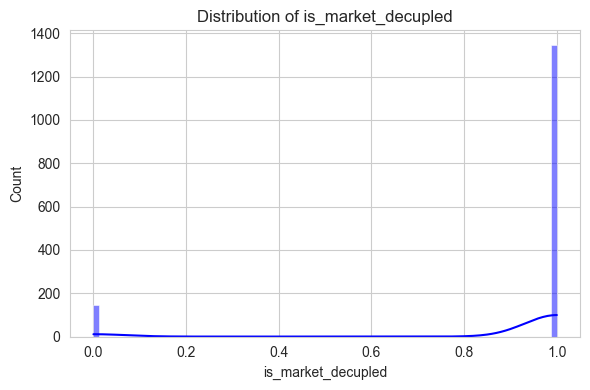

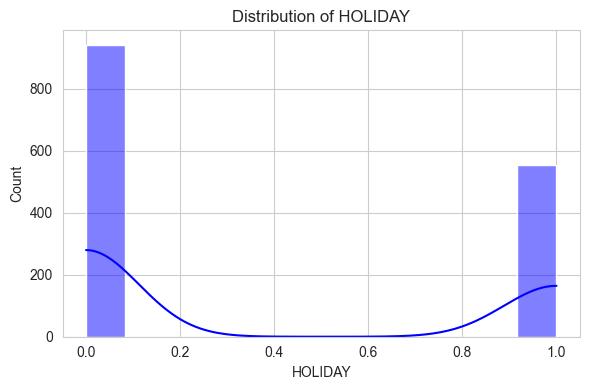

In [61]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load your dataset
df = X_train_processed  # Replace with your file path

# Loop through columns and plot distributions
for col in df.columns:
    plt.figure(figsize=(6, 4))
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(df[col], kde=True, color="blue")
        plt.title(f"Distribution of {col}")
    else:
        sns.countplot(x=df[col], palette="Set2")
        plt.title(f"Frequency of {col}")
    plt.tight_layout()
    plt.show()


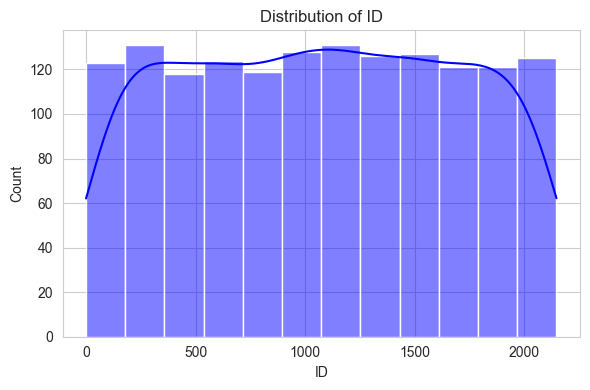

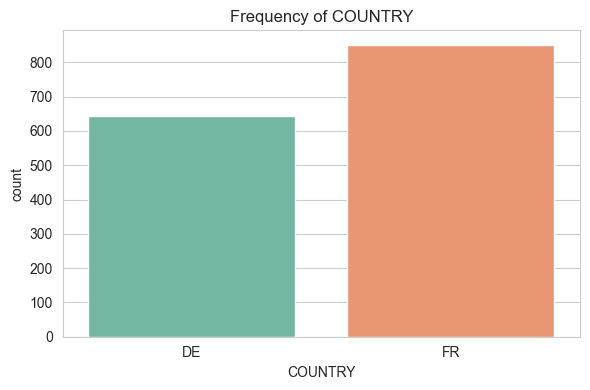

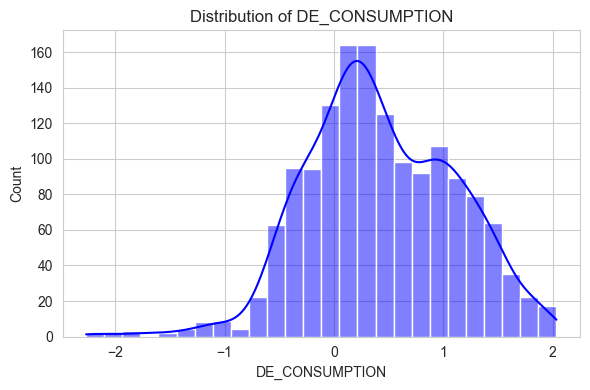

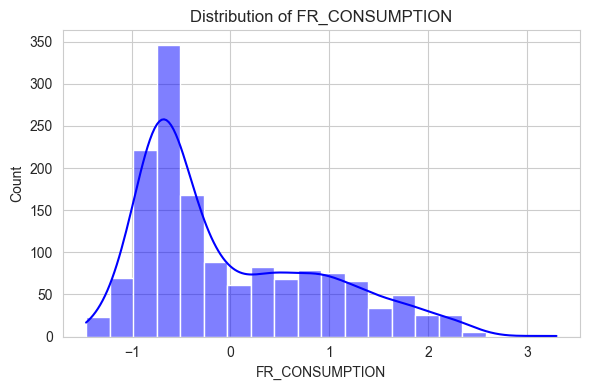

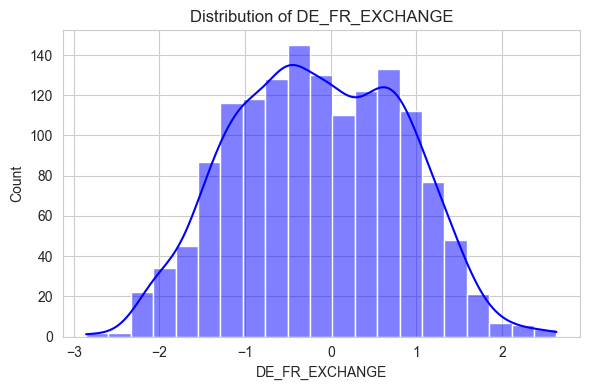

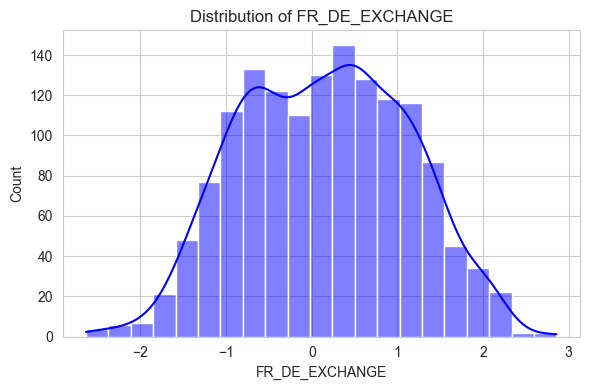

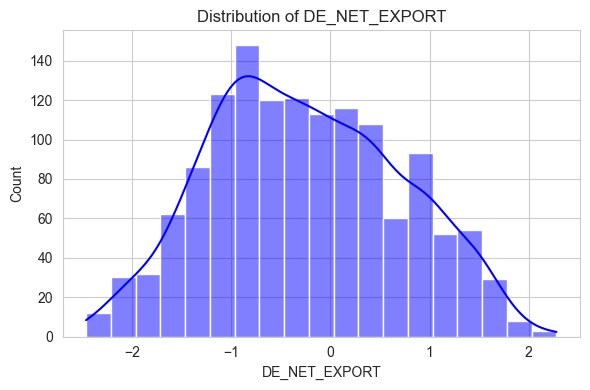

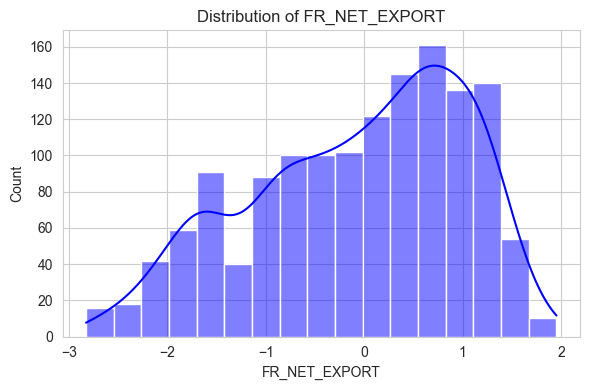

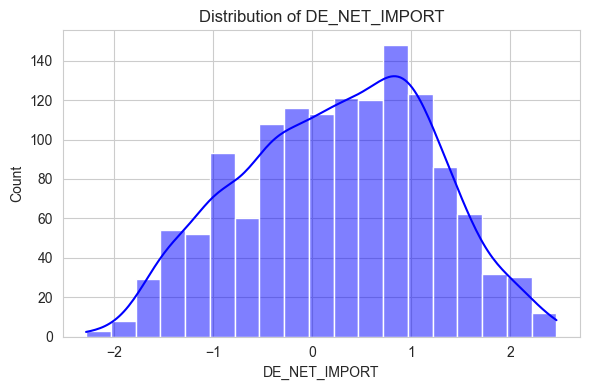

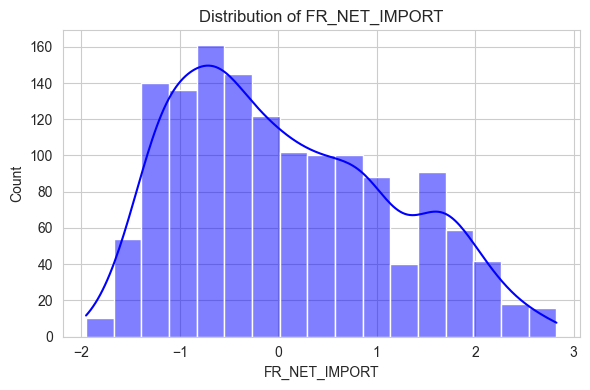

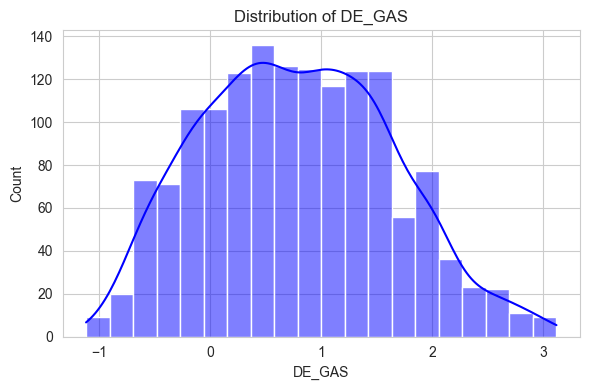

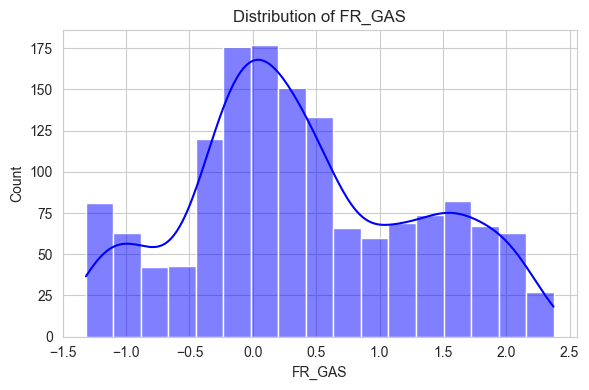

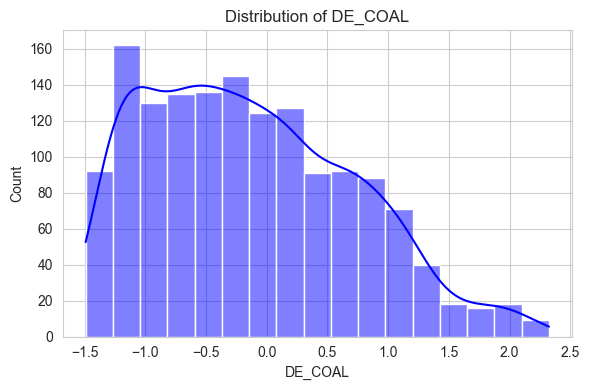

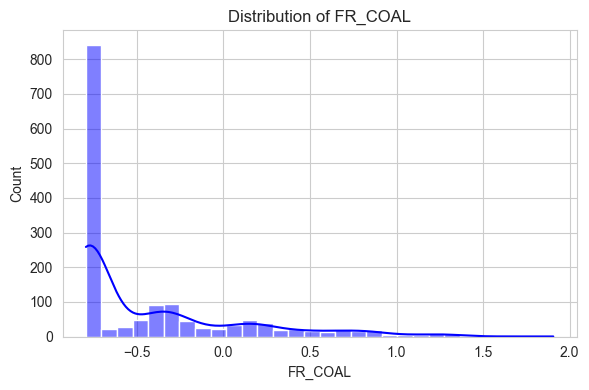

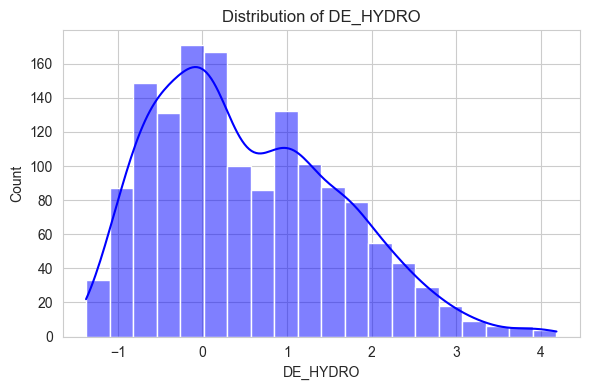

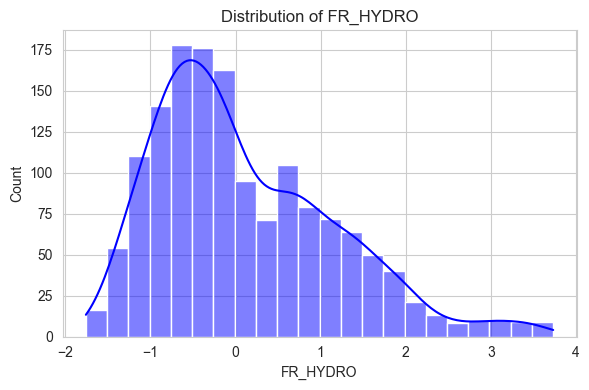

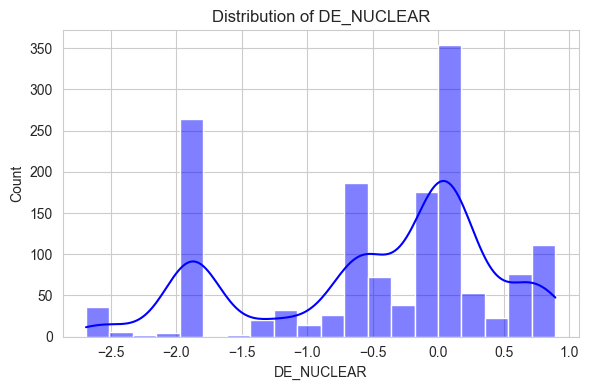

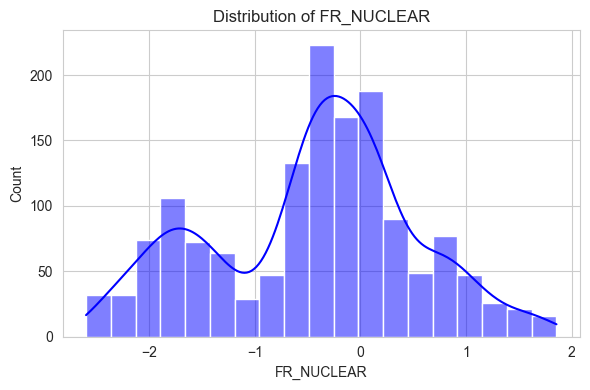

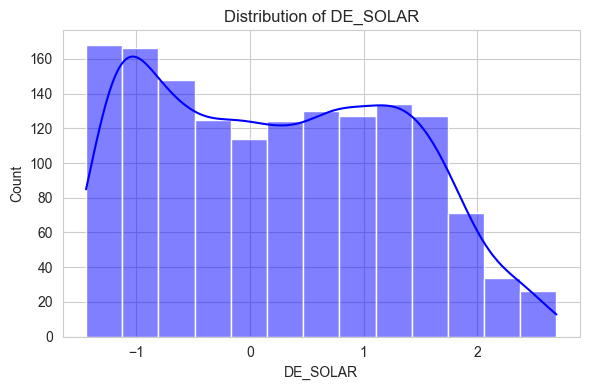

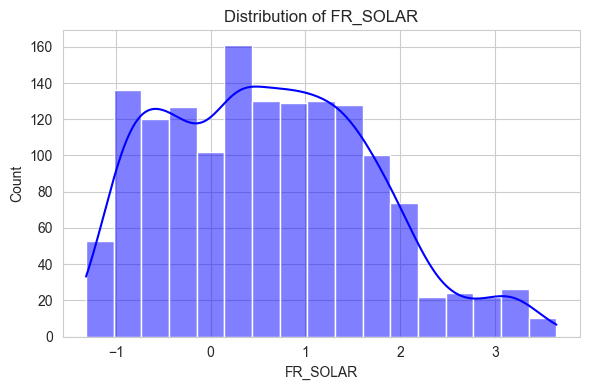

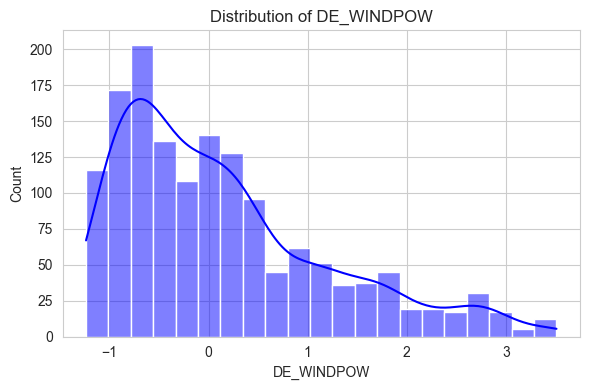

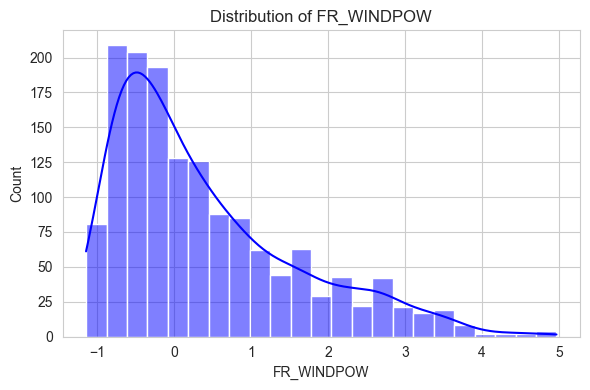

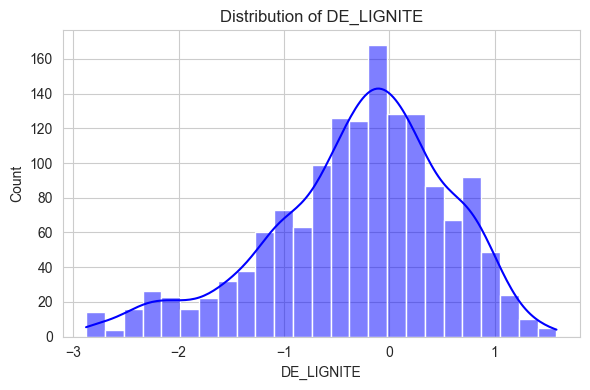

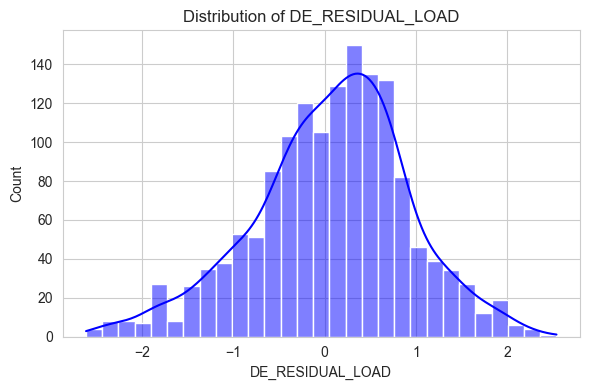

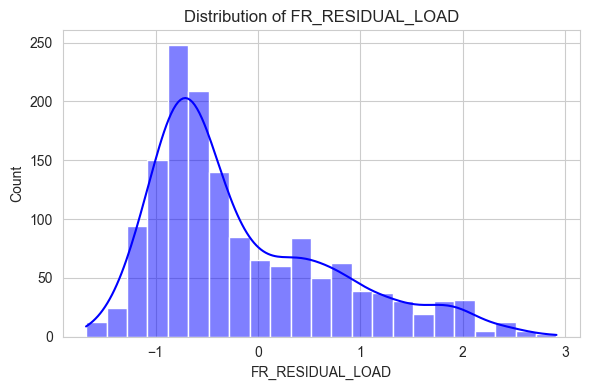

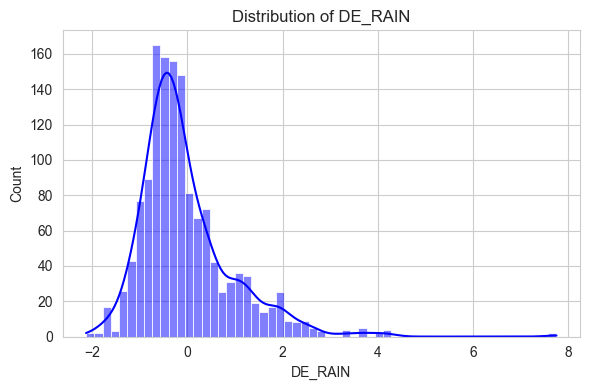

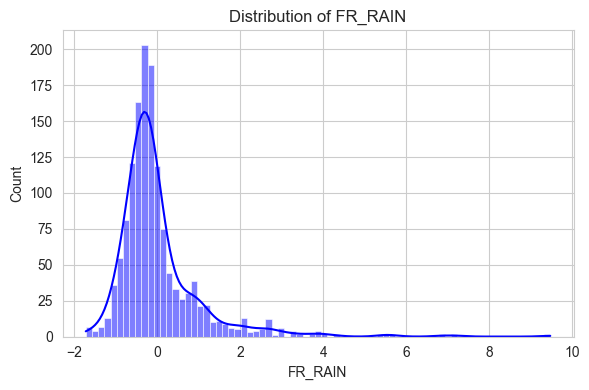

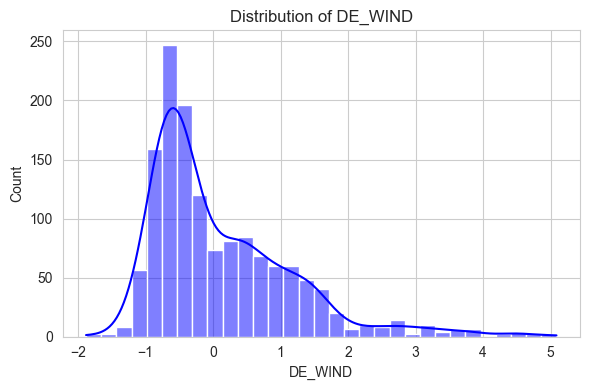

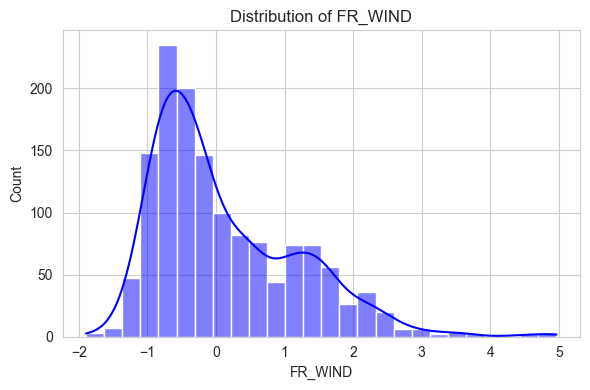

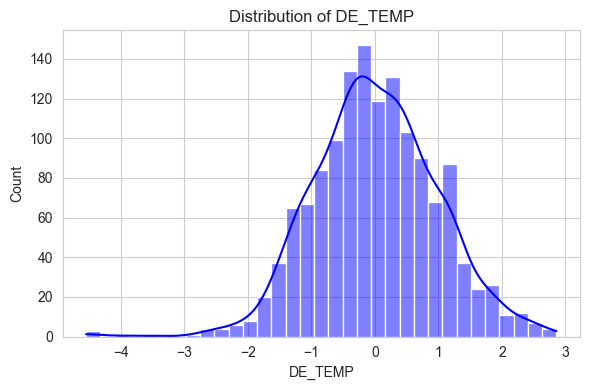

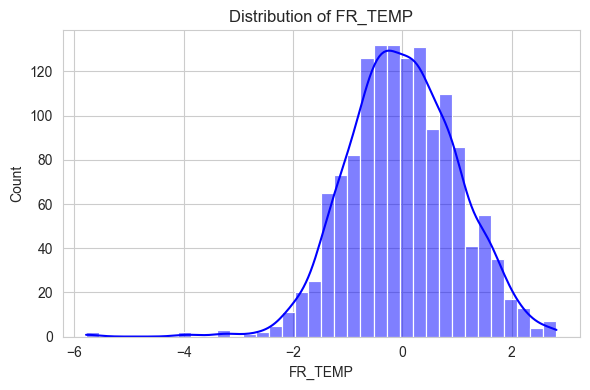

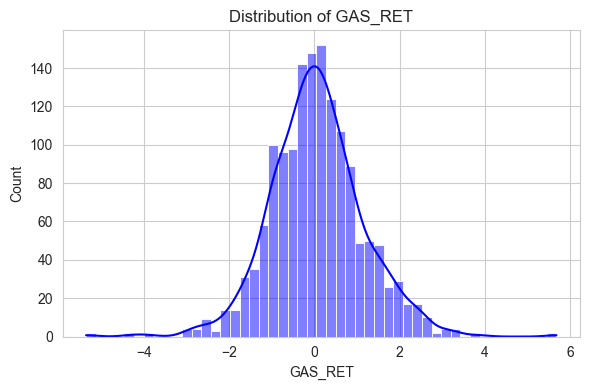

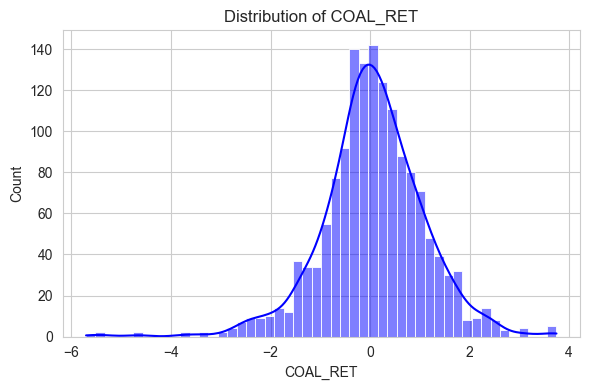

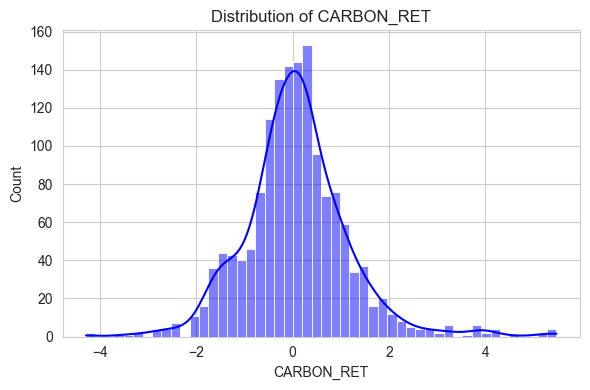

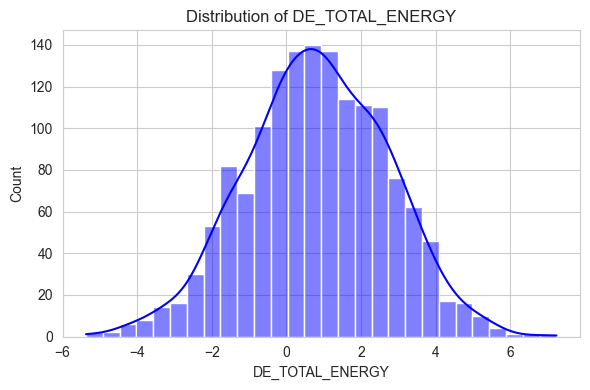

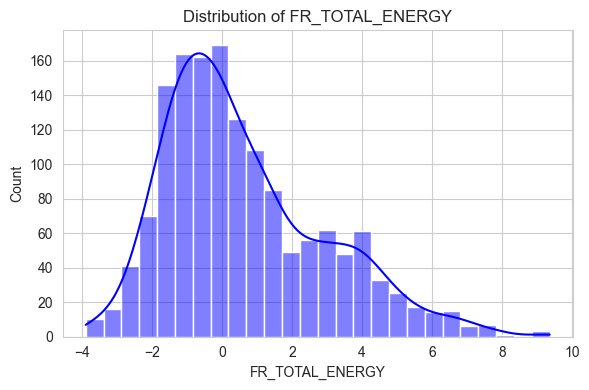

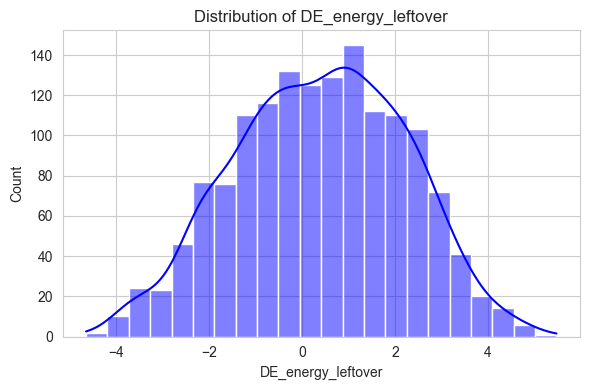

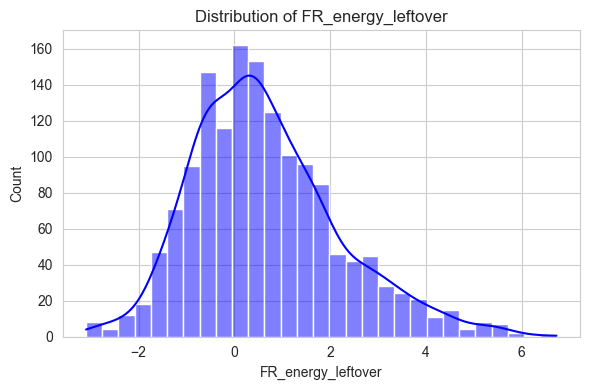

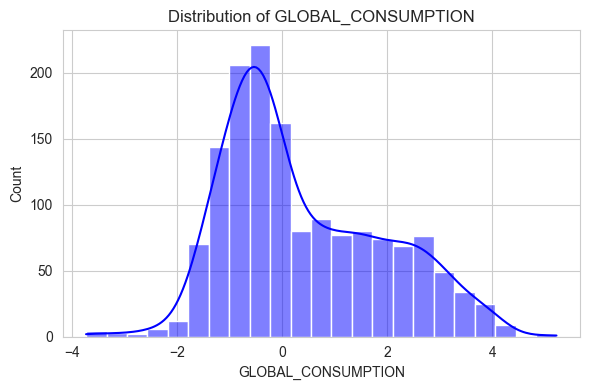

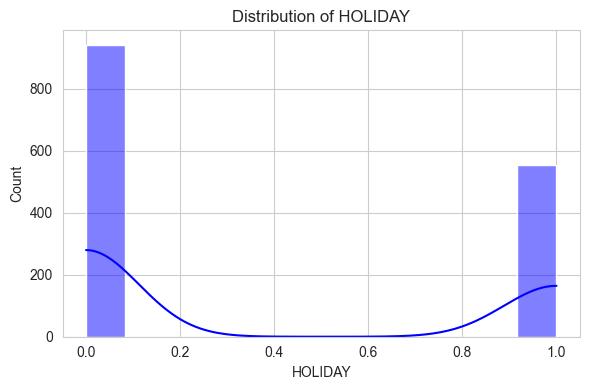

In [25]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load your dataset
df = X_train_processed  # Replace with your file path

# Loop through columns and plot distributions
for col in df.columns:
    plt.figure(figsize=(6, 4))
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(df[col], kde=True, color="blue")
        plt.title(f"Distribution of {col}")
    else:
        sns.countplot(x=df[col], palette="Set2")
        plt.title(f"Frequency of {col}")
    plt.tight_layout()
    plt.show()
